<a href="https://colab.research.google.com/github/el-grudge/01--Introduction-to-DataCamp-Projects/blob/master/resnet_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters
num_epochs = 10
learning_rate = 0.001

In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [ ]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [ ]:
test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/10], Step [100/500] Loss: 1.8459
Epoch [1/10], Step [200/500] Loss: 1.3767
Epoch [1/10], Step [300/500] Loss: 1.3867
Epoch [1/10], Step [400/500] Loss: 1.0610
Epoch [1/10], Step [500/500] Loss: 1.0776
Epoch [2/10], Step [100/500] Loss: 1.0311
Epoch [2/10], Step [200/500] Loss: 1.0876
Epoch [2/10], Step [300/500] Loss: 0.8648
Epoch [2/10], Step [400/500] Loss: 1.0252
Epoch [2/10], Step [500/500] Loss: 1.1292
Epoch [3/10], Step [100/500] Loss: 1.0464
Epoch [3/10], Step [200/500] Loss: 0.8076
Epoch [3/10], Step [300/500] Loss: 0.8713
Epoch [3/10], Step [400/500] Loss: 0.8458
Epoch [3/10], Step [500/500] Loss: 0.8322
Epoch [4/10], Step [100/500] Loss: 0.6230
Epoch [4/10], Step [200/500] Loss: 0.6165
Epoch [4/10], Step [300/500] Loss: 0.8043
Epoch [4/10], Step [400/500] Loss: 0.7574
Epoch [4/10], Step [500/500] Loss: 0.6344
Epoch [5/10], Step [100/500] Loss: 0.6472
Epoch [5/10], Step [200/500] Loss: 0.7683
Epoch [5/10], Step [300/500] Loss: 0.4279
Epoch [5/10], Step [400/500] Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 74.62 %


# Generating an adversarial example, and applying an attack

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1) # usually used with MNIST
    # Return the perturbed image
    return perturbed_image

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=False)

In [ ]:
dataiter = iter(test_loader)
image, label = dataiter.next()

In [ ]:
image.requires_grad = True
output = model(image.to(device))
init_pred = torch.max(output.data, 1)[1] # save the initial prediction
loss = criterion(output, label.to(device))
model.zero_grad()
loss.backward()
data_grad = image.grad.data
epsilon = .05
perturbed_image = fgsm_attack(image, epsilon, data_grad)
adv_output = model(perturbed_image.to(device))
adv_pred = torch.max(adv_output.data, 1)[1] # save the prediction of the adversarial sample

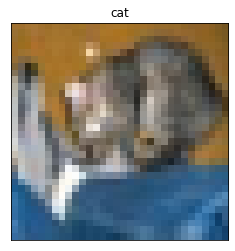

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.imshow(image.squeeze().detach().numpy().transpose((1,2,0)))
plt.xticks([])
plt.yticks([])
title_obj = plt.title(classes[init_pred])

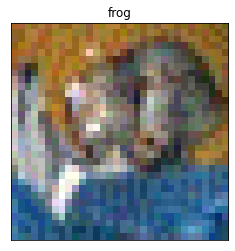

In [ ]:
plt.imshow(perturbed_image.squeeze().detach().numpy().transpose((1,2,0)))
plt.xticks([])
plt.yticks([])
title_obj = plt.title(classes[adv_pred])